In [101]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm


from PIL import Image, ImageDraw
import glob
import os
import matplotlib.pyplot as plt
import math 


import scipy.misc as smp

import json
from datetime import datetime

from operator import add
import re

from scipy.optimize import curve_fit
from scipy.integrate import quad


In [2]:
# include functions 
%run phase02-mask-generation/SugarUtils.py

./tiles/tile-x7620-y7600.png
./geometries/geo-x7620-y7600.geojson
./mask/mask-x7620-y7600.png


In [3]:
mask_files = f"./Phase02-DataDelivery/masks/*.png"
mask_images = glob.glob(mask_files)

# get all the x, y positions of tiles from masks file name
xy_pair = []
for mask_img in mask_images:
    mask_list = re.findall(r'\d+', mask_img)
    xy_pair.append( (mask_list[1],mask_list[2]) )

In [59]:
xy_pair
# len(xy_pair)

[('6144', '5120'),
 ('6144', '7680'),
 ('5632', '7168'),
 ('4608', '6144'),
 ('6656', '6144'),
 ('6656', '8192'),
 ('5632', '8704'),
 ('7168', '10240'),
 ('5120', '6656'),
 ('2048', '1024'),
 ('7680', '9728'),
 ('5120', '4096'),
 ('1536', '1536'),
 ('6656', '9728'),
 ('7168', '5120'),
 ('6656', '4608'),
 ('5632', '5632'),
 ('4608', '4608'),
 ('6656', '9216'),
 ('6144', '8704'),
 ('6656', '6656'),
 ('6656', '4096'),
 ('6656', '10240'),
 ('6144', '5632'),
 ('7168', '7168'),
 ('5120', '4608'),
 ('6144', '7168'),
 ('7168', '5632'),
 ('5632', '5120'),
 ('2048', '1536'),
 ('8704', '10240'),
 ('5632', '7680'),
 ('5120', '6144'),
 ('1536', '1024'),
 ('4608', '5632'),
 ('5632', '4608'),
 ('8192', '10240'),
 ('6656', '5632'),
 ('6144', '6656'),
 ('6144', '4096'),
 ('5632', '8192'),
 ('6656', '8704'),
 ('7680', '5632'),
 ('6144', '9216'),
 ('7168', '6656'),
 ('7168', '4096'),
 ('5632', '6144'),
 ('5120', '3584'),
 ('5120', '5120'),
 ('6656', '7168'),
 ('6144', '6144'),
 ('7680', '5120'),
 ('4608'

In [58]:
# E.g. get mask png data
tile_x, tile_y = xy_pair[0][0], xy_pair[0][1]
print( tile_x, " ", tile_y )
mask_file_path = f"./Phase02-DataDelivery/masks/mask-x{tile_x}-y{tile_y}.png"
img = Image.open(mask_file_path)
pixels = img.load()

print(img.size)


# why is alpha 255?  alpha range from 0 to 255 (also range from 0 to 1)
# 0 being completely transparent, 255 being completely opaque
# (0,0,0,255) means black

def get_mask_list(pixels):
    mask_list = []

    for x in range(0,512):
        for y in range(0,512):
            if pixels[y,x] == (0,0,0,255):
                mask_list.append((y,x))
    return mask_list



6144   5120
(512, 512)


In [5]:
def get_timeseries_image_paths(tile_x, tile_y, band):
    path = f"./Phase02-DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-{band}*.png"
    images = glob.glob(path)
    return images

In [8]:
tile_x = xy_pair[0][0]
tile_y = xy_pair[0][1]
# band_img = get_timeseries_image_paths(tile_x, tile_y, "TCI") 
band_img_RED = get_timeseries_image_paths(tile_x, tile_y, "B04")   # B04 is red
# band_img_NIR = get_timeseries_image_paths(tile_x, tile_y, "B08")   # B08 is NIR

In [9]:
# need to sort the band_img list
# sort the image path according to timeseries

def get_image_path_dict(band_img):
    image_path_dict = {}
    for bi in band_img:
        timestr = bi[-14:][:10]
        t = datetime.strptime(timestr, '%Y-%m-%d')
        image_path_dict[t] = bi
    return image_path_dict

In [10]:
# get time series for TCI
timeseries_list = []
for bi in band_img_RED:
    timestr = bi[52:62]
    timeseries_list.append(timestr)

# sorted timeseries_list
timeseries_list.sort(key = lambda date: datetime.strptime(date, '%Y-%m-%d'))

In [12]:
# timeseries_list     # sorted

In [14]:
# store sugacrane pixel to tci_list
def get_sugarcrane_region_from_tci(mask_list, band_pixels):
    tci_list = []

    for mask_ind in mask_list:
        y = mask_ind[0]
        x = mask_ind[1]

        tci_list.append(band_pixels[y,x])
    return tci_list



In [15]:
# store sugacrane pixel to list, then store all the images to dict, 
# key is timestamp, value is list

def get_tci_dict(image_path_dict, mask_list):
    tci_dict = {}
    cnt = 0
    for elem in sorted(image_path_dict.keys()):
    #     mask_list = 

        path = image_path_dict[elem]
        img = Image.open(path)
        band_pixels = img.load()

        tci_list = get_sugarcrane_region_from_tci(mask_list, band_pixels)
        tci_dict[cnt] = tci_list
        cnt += 1
    return tci_dict
    

In [28]:
# the first xy pair 
tile_x, tile_y = xy_pair[0][0], xy_pair[0][1]
mask_file_path = f"./Phase02-DataDelivery/masks/mask-x{tile_x}-y{tile_y}.png"
img = Image.open(mask_file_path)
pixels = img.load()

mask_list = get_mask_list(pixels)
band_img_RED = get_timeseries_image_paths(tile_x, tile_y, "B04")
image_path_dict_RED = get_image_path_dict(band_img_RED)
red_dict = get_tci_dict(image_path_dict_RED, mask_list)

band_img_NIR = get_timeseries_image_paths(tile_x, tile_y, "B08")
image_path_dict_NIR = get_image_path_dict(band_img_NIR)
nir_dict = get_tci_dict(image_path_dict_NIR, mask_list)

In [47]:
# len(tci_dict)    # 71 days
len(red_dict[10])        # values in only sugarcane regions 175950 pixels, for a particular tile

175950

In [26]:
# Kumar-Monteith Model
# need to get NDVI curve first 



In [43]:
# NDVI curve

# get only 2017.09.28 to 2018.10.03
# timeseries_list[21]    # 2017.09.28
# timeseries_list[49]    # 2018.10.03

# print( nir_dict[1][:10] )
# print( red_dict[1][:10] )
arr1 = np.array(nir_dict[1][:10])
arr2 = np.array(red_dict[1][:10])
print( np.divide( np.subtract(arr1, arr2), np.add(arr1, arr2) ) )




'2018-10-03'

In [50]:
# for a particular tile
ndvi_for_tile = []
for day in list(range(21,50)):
    nir_arr = np.array( nir_dict[day] )
    red_arr = np.array( red_dict[day] )
    
    ndvi_array = np.divide( np.subtract(nir_arr, red_arr), np.add(nir_arr, red_arr) )
    
    # print( ndvi_array.mean() )
    appr_ndvi = ndvi_array.mean()
    ndvi_for_tile.append( appr_ndvi )
    
print( ndvi_for_tile )   

[0.20488480265717954, 0.1859512751839128, 0.3507618056878361, 0.4118606538609533, 0.3215783817010941, 0.4936062061635348, 0.5316695393994335, 0.517958678893894, 0.5404314241957242, 0.25676093085546964, 0.22180487666968762, 0.0709691999451856, 0.4915880209564313, 0.47753091550138105, 0.6619861374050291, 0.12423731637388076, 0.14898473119989342, 0.585373576017535, 0.5527928135372291, 0.34659179338515506, 0.49887347004497257, 0.5046130808416717, 0.4284505914447084, 0.33428148478302044, 0.25291611485772375, 0.27929430185719617, 0.29695278545174536, 0.2186175025162925, 0.24319189007663802]


In [57]:
ndvi_for_tile[15]
timeseries_list[21+15]

'2018-05-06'

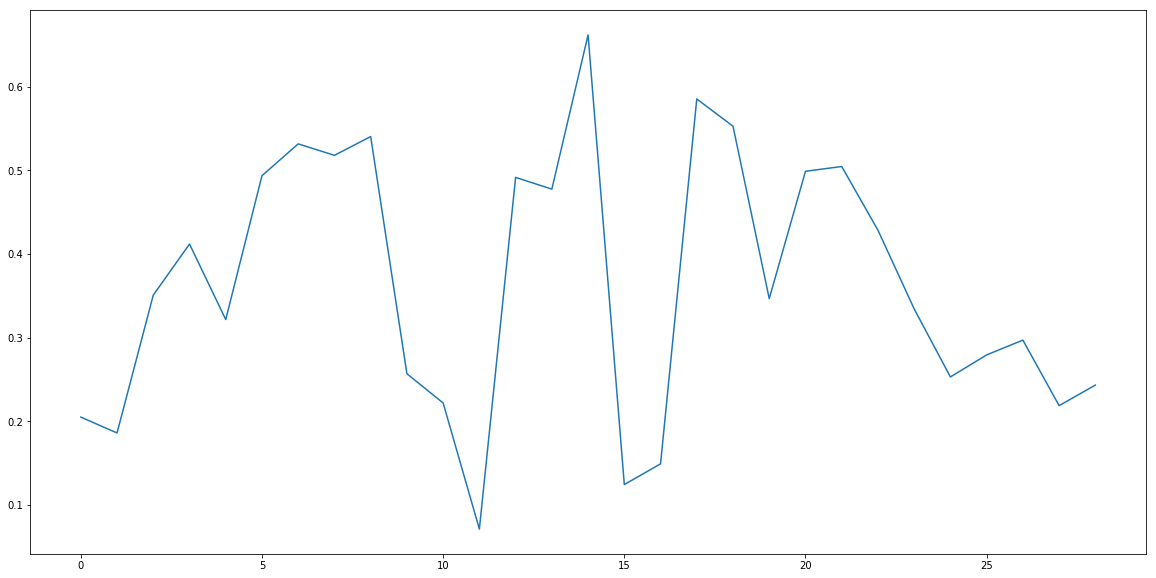

In [52]:
plt.figure(figsize=(20,10))
x = list(range(0, (50-21)))
plt.plot(x,ndvi_for_tile)
plt.show()

# the cloud definitely has huge effect 
# this is for tile x6144-y5120

In [63]:
# try colour method for now 


with open("tile_xy_dict.json",'r') as fp:
    tile_xy_dict = json.load(fp)

greensum_df = pd.DataFrame.from_dict(tile_xy_dict)
greensum_df.head(10)

,x6144-y5120,x6144-y7680,x5632-y7168,x4608-y6144,x6656-y6144,x6656-y8192,x5632-y8704,x7168-y10240,x5120-y6656,x2048-y1024,...,x7168-y9728,x6656-y5120,x7168-y4608,x5120-y5632,x7680-y10240,x6144-y4608,x6144-y9728,x5632-y6656,x5632-y4096,x6144-y8192
0,91481,45694,11562,354,2385,26562,8044,76488,14695,403,...,18691,63052,11227,83317,126421,65351,274,1628,23139,33606
1,108012,43616,11467,421,1771,33040,13687,91449,13490,400,...,24951,80812,9367,84475,136551,66444,1311,867,24150,31842
2,133676,55458,15350,507,2152,41573,15207,89387,31188,435,...,25500,78800,10889,132185,133200,75303,1923,1961,33101,45448
3,154892,60923,19151,907,3050,46997,14516,97686,34779,705,...,23281,112460,9661,144192,156598,82406,1583,1911,32881,45411
4,156853,74290,19553,1012,2859,56434,18074,101605,34581,680,...,28694,99304,14485,141616,161063,90527,1880,2061,34145,52453
5,154195,69902,19094,1049,2700,56479,18972,89196,32281,424,...,24063,96185,14266,141615,148648,87152,1904,1985,34279,49947
6,149408,67620,18629,726,2726,54295,18419,92974,33903,522,...,25021,112241,14174,141332,152254,89644,1704,2329,33505,46114
7,137710,68810,18891,677,2892,55860,19297,104724,34165,424,...,29157,104343,14365,142514,160118,90100,1930,2313,33419,51015
8,141324,68671,18828,692,3004,54952,19247,103911,33485,410,...,28994,106202,14036,142431,160406,89348,1930,2297,32648,50675
9,125059,68519,18828,442,3004,53079,11553,103899,25899,161,...,28994,82289,9744,125121,158971,76863,1751,2297,28071,43601


In [179]:
greensum_df["time"] = timeseries_list
greensum_df.head()

,x6144-y5120,x6144-y7680,x5632-y7168,x4608-y6144,x6656-y6144,x6656-y8192,x5632-y8704,x7168-y10240,x5120-y6656,x2048-y1024,...,x6656-y5120,x7168-y4608,x5120-y5632,x7680-y10240,x6144-y4608,x6144-y9728,x5632-y6656,x5632-y4096,x6144-y8192,time
0,91481,45694,11562,354,2385,26562,8044,76488,14695,403,...,63052,11227,83317,126421,65351,274,1628,23139,33606,2016-12-22
1,108012,43616,11467,421,1771,33040,13687,91449,13490,400,...,80812,9367,84475,136551,66444,1311,867,24150,31842,2017-01-01
2,133676,55458,15350,507,2152,41573,15207,89387,31188,435,...,78800,10889,132185,133200,75303,1923,1961,33101,45448,2017-01-11
3,154892,60923,19151,907,3050,46997,14516,97686,34779,705,...,112460,9661,144192,156598,82406,1583,1911,32881,45411,2017-02-10
4,156853,74290,19553,1012,2859,56434,18074,101605,34581,680,...,99304,14485,141616,161063,90527,1880,2061,34145,52453,2017-02-20


In [180]:
# greensum_df.to_csv("tile_xy_dict.csv", index=False)

In [186]:
# greensum_df.drop(["time"], axis=1).columns.tolist()
greensum_df['x6144-y5120'].values

array([ 91481, 108012, 133676, 154892, 156853, 154195, 149408, 137710,
       141324, 125059, 151495, 115908,  88305, 145008, 105942, 129939,
        90791, 109685,  93212,  62873,  43482,  21545,  21556,  75558,
        95775, 102436, 140352, 150189, 146198, 148261, 132875, 129331,
       129019, 153518, 161656, 165040, 119835,  98349, 149234, 146697,
        91179, 125348, 123474, 109569,  84784,  41652,  49813,  41802,
        30619,  25344,  17636,  30970,  65216,  74947,  66710,  66710,
       121538, 160044, 147624, 151224, 152408, 149204, 135822, 160627,
       160312, 108894, 158092, 153165, 146580, 129222, 141792])

In [65]:
season1718_df = greensum_df.iloc[21:50]

In [67]:
# season1718_df = season1718_df.reset_index(drop=True)

season1718_df.info()

,x6144-y5120,x6144-y7680,x5632-y7168,x4608-y6144,x6656-y6144,x6656-y8192,x5632-y8704,x7168-y10240,x5120-y6656,x2048-y1024,...,x7168-y9728,x6656-y5120,x7168-y4608,x5120-y5632,x7680-y10240,x6144-y4608,x6144-y9728,x5632-y6656,x5632-y4096,x6144-y8192
0,21545,11712,2941,24,205,7016,1585,18186,4520,202,...,4116,20872,2620,15156,25523,9953,4,111,478,6513
1,21556,8282,1928,17,2,4874,1145,14964,3559,352,...,3640,13482,1738,13937,23545,10102,32,41,1285,4200
2,75558,23617,2726,663,187,11235,1283,34787,8227,728,...,15422,24811,4009,41463,58766,21168,586,134,9699,14354
3,95775,38116,6062,944,715,13079,3260,49667,14546,368,...,17595,42382,4496,57676,82503,32037,1346,56,16743,25719
4,102436,49714,11983,1043,2105,27555,3213,49449,22448,542,...,14423,64042,8261,72803,80607,29551,1308,331,15542,32076


In [69]:
# season1718_df.info()

In [70]:
season1718_total = season1718_df.sum(axis=1)

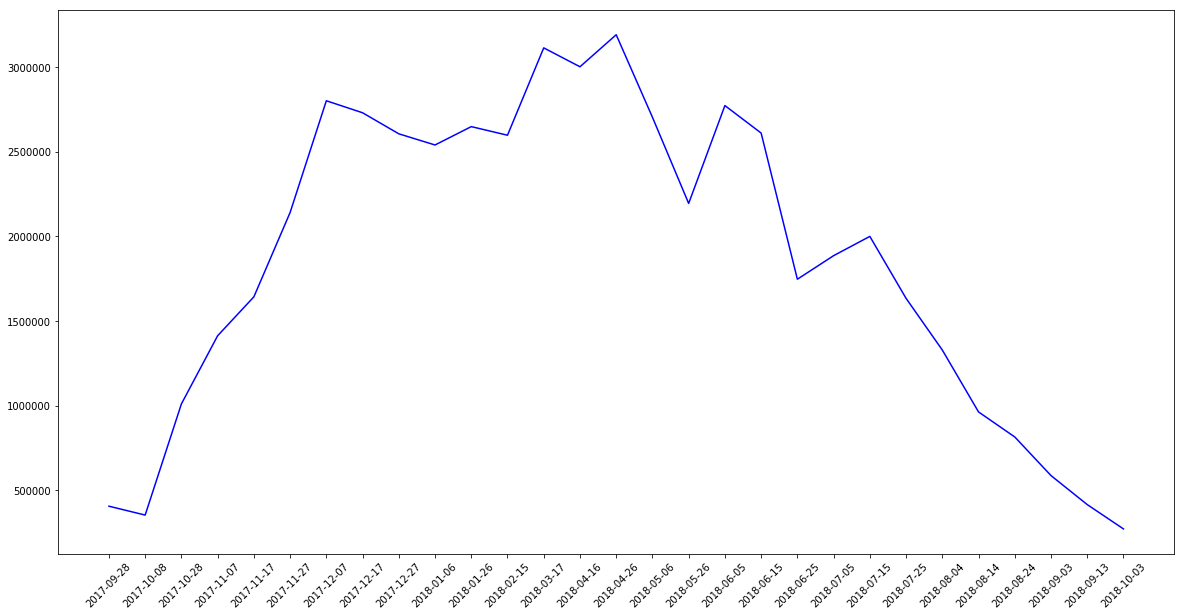

In [73]:
plt.figure(figsize=(20,10))
x = timeseries_list[21:50]
plt.plot(x, season1718_total, 'b-')
plt.xticks(rotation=45)
plt.show()

# mark 2018.06.15 for harvest start date

In [212]:
# NDVI file 


with open("tile_xy_ndvi_dict.json",'r') as fp:
    tile_xy_ndvi_dict = json.load(fp)

ndvi_df = pd.DataFrame.from_dict(tile_xy_ndvi_dict)
ndvi_df.head(10)


,x6144-y5120,x6144-y7680,x5632-y7168,x4608-y6144,x6656-y6144,x6656-y8192,x5632-y8704,x7168-y10240,x5120-y6656,x2048-y1024,...,x7168-y9728,x6656-y5120,x7168-y4608,x5120-y5632,x7680-y10240,x6144-y4608,x6144-y9728,x5632-y6656,x5632-y4096,x6144-y8192
0,0.364494,0.344400,0.326713,0.313370,0.428693,0.276696,0.305396,0.391857,0.268395,0.240446,...,0.341313,0.374479,0.472883,0.363848,0.423404,0.423498,0.170243,0.346907,0.439220,0.338001
1,0.409105,0.331021,0.333961,0.376479,0.421396,0.331202,0.474344,0.527118,0.303987,0.243657,...,0.520391,0.449534,0.415945,0.369552,0.522723,0.433807,0.374263,0.257608,0.451124,0.350494
2,0.389057,0.436278,0.451120,0.400864,0.485331,0.408035,0.489420,0.533821,0.490616,0.300776,...,0.507525,0.397568,0.388663,0.492637,0.478239,0.450289,0.525915,0.566558,0.543971,0.474021
3,0.562660,0.467544,0.546479,0.570794,0.612473,0.442532,0.474757,0.576723,0.592805,0.511510,...,0.465995,0.611411,0.396661,0.574996,0.587395,0.516813,0.395670,0.602935,0.545653,0.522479
4,0.598796,0.580213,0.549328,0.620328,0.517352,0.548982,0.637529,0.660605,0.534005,0.404750,...,0.629047,0.573969,0.578268,0.569885,0.605032,0.614853,0.599523,0.565725,0.612197,0.606348
5,0.552257,0.546081,0.648424,0.654734,0.509492,0.492526,0.663320,0.555090,0.535830,0.329663,...,0.518376,0.533720,0.559302,0.551145,0.541353,0.556512,0.591159,0.513224,0.609207,0.558359
6,0.570119,0.529451,0.628445,0.556465,0.581266,0.516105,0.610513,0.563297,0.583425,0.350177,...,0.528408,0.654115,0.632119,0.591732,0.562879,0.621074,0.496968,0.712314,0.596306,0.529851
7,0.516399,0.554598,0.580535,0.491145,0.550366,0.527384,0.647344,0.623899,0.567078,0.324210,...,0.618737,0.524517,0.532609,0.543147,0.598321,0.544155,0.614340,0.624043,0.542927,0.586020
8,0.499769,0.535556,0.568058,0.481045,0.538360,0.502236,0.622332,0.610017,0.521259,0.293816,...,0.610873,0.503595,0.508863,0.529969,0.591295,0.515356,0.602012,0.604491,0.522140,0.567131
9,0.449108,0.534239,0.568058,0.357564,0.538360,0.487804,0.432534,0.609959,0.425636,0.164685,...,0.610873,0.362712,0.388269,0.482401,0.586823,0.430561,0.563803,0.604491,0.404557,0.505280


In [233]:
# ndvi_df["time"] = timeseries_list
# ndvi_df.to_csv("tile_xy_ndvi_dict.csv", index=False)

In [214]:
ndvi_y = ndvi_df.mean(axis=1).values

In [217]:
season1718_ndvi_df = ndvi_df.iloc[21:50]
season1718_ndvi_mean = season1718_ndvi_df.mean(axis=1).values

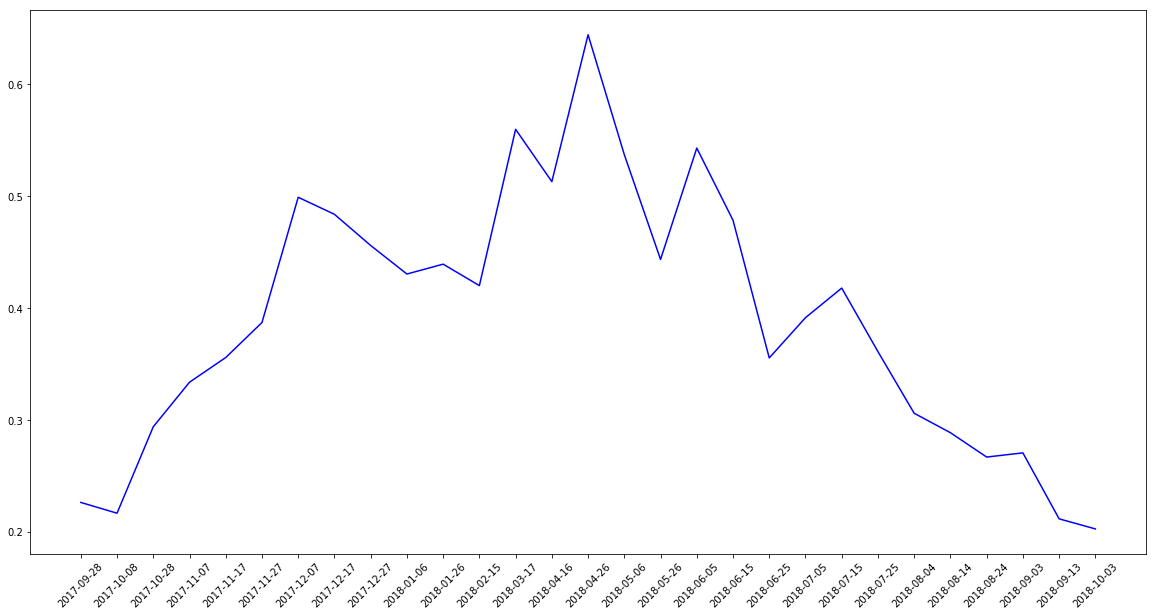

In [218]:
plt.figure(figsize=(20,10))
x = timeseries_list[21:50]
plt.plot(x, season1718_ndvi_mean, 'b-')
plt.xticks(rotation=45)
plt.show()


In [96]:
# fit NDVI function to the data

def NDVI_func(x, m, a, b, ti, tf):
    return m / ( 1 +  np.exp((-1) * a * (x - ti)))  -  m / ( 1 +  np.exp((-1) * b * (x - tf)))


In [234]:
timeseries_list[21+18]

'2018-06-15'

In [219]:
ydata = season1718_ndvi_mean[:18]
len(ydata)

18

In [220]:
ydata

array([0.22615438, 0.21651557, 0.29383668, 0.33367177, 0.35575447,
       0.38706845, 0.49908376, 0.4838351 , 0.45595983, 0.43042955,
       0.43926377, 0.42008557, 0.55985977, 0.51305607, 0.64444444,
       0.53720647, 0.4434728 , 0.54309831])

In [221]:
xdata = np.array( list(range(0, 18)) )
ydata = np.array( season1718_ndvi_mean[:18] )
popt, pcov = curve_fit(NDVI_func, xdata, ydata)

In [222]:
m, a, b, ti, tf = popt[0], popt[1], popt[2], popt[3], popt[4]


In [223]:
NDVI_func(xdata, m, a, b, ti, tf)

array([0.21066981, 0.25012965, 0.29027292, 0.32929251, 0.36557583,
       0.39795067, 0.42579138, 0.44898318, 0.4677957 , 0.48272964,
       0.49438255, 0.50335389, 0.51018952, 0.51535686, 0.51923976,
       0.5221444 , 0.52430994, 0.52592039])

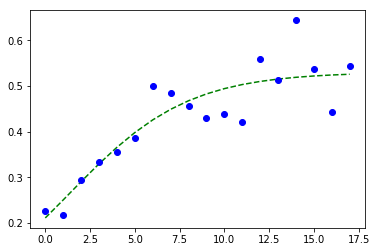

In [224]:
plt.plot(xdata, NDVI_func(xdata, *popt), 'g--')
plt.plot(xdata, ydata, 'bo')
plt.show()

In [225]:

ydata = np.array( season1718_ndvi_mean[:18] )
xdata = np.array( list(range(0, len(ydata))) )
# testydata = ydata * 0.0000001
# testydata

In [226]:
from scipy.optimize import least_squares

def fun(x, t, y):
    m, a, b, ti, tf = x[0], x[1], x[2], x[3], x[4]
    return NDVI_func(t, m, a, b, ti, tf) - y
x0 = np.ones(5)
res_lsq = least_squares(fun, x0, args=(xdata, ydata))

# reference: https://scipy-cookbook.readthedocs.io/items/robust_regression.html

In [227]:
res_lsq.x

array([  0.58517436,   0.29786019,  -0.062126  ,  -0.70629908,
       -21.52063093])

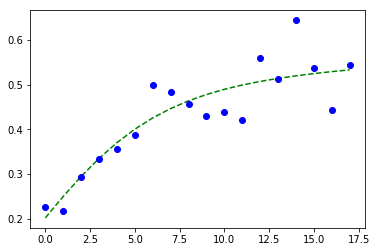

In [229]:
plt.plot(xdata, NDVI_func(xdata, *res_lsq.x), 'g--')
plt.plot(xdata, ydata, 'bo')
plt.show()

# the line is wrong because the y value should be NDVI, range from -1 to 1, not green sum
# and the x value should be thermal age not age 

In [230]:
# I = quad(NDVI_func, 0, 17, args=(m, a, b, ti, tf) )
m, a, b, ti, tf = res_lsq.x[0], res_lsq.x[1], res_lsq.x[2], res_lsq.x[3], res_lsq.x[4]
I = quad(NDVI_func, 0, 17, args=(m, a, b, ti, tf) )
I
# corresponding to 17/18 proserpine sugarcane yield 
# need to do linear regression 

(7.418822410624586, 3.5896563136300383e-12)

In [109]:
# observed value for sugarcane yield in Proserpine for 17/18 = 66.0   (unit = Tonnes of cane per hectare, t/ha)
true_yield = 66.0


In [231]:
def predict_yield(x):
    return (66.0 / I[0]) * x

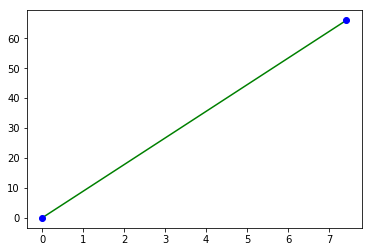

In [232]:
xx = np.array([0, I[0]])
yy = np.array([0, true_yield])
plt.plot(xx, predict_yield(xx), 'g-')
plt.plot(xx, yy, 'bo')
plt.show()

In [ ]:
# design API calls
# no need for customised regions 
# just use this 65 tile as regions for Proserpine 


# APIs
# getEstimatedYield( ratoonStartDate, harvestStartDate, regionId )
#    ratoonStartDate:   the date when last harvest just finishes, and regrow starts
#    harvestStartDate:  the date when starting to harvest the sugarcane 
#    regionId:          the id that corresponds to a certain region in Proserpine, from a total of 65 regions
# return: the estimated yield for that region 



In [197]:
from datetime import datetime

datetime_object = datetime.strptime(timeseries_list[1], '%Y-%m-%d')
datetime_object2 = datetime.strptime(timeseries_list[2], '%Y-%m-%d')
datetime_object3 = datetime.strptime(timeseries_list[3], '%Y-%m-%d')
min([datetime_object2 - datetime_object, datetime_object3 - datetime_object])

datetime.timedelta(days=10)

In [198]:
datetime_object3.strftime('%Y-%m-%d')

'2017-02-10'

In [211]:
timeseries_list.index('2017-02-10')

3